# Transformers fine-tune with custom data set

In [1]:
!pip install transformers
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
import torch
#Initially gpu not available
torch.cuda.is_available()

True

In [3]:
torch.cuda.current_device()

0

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split




In [6]:
df_ = pd.read_csv('Tweets.csv')

In [7]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
df = df_[['airline_sentiment','text']]
#df = df_[['airline_sentiment','text']].copy()
#2nd command has same result as 1st command
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [9]:
#create test set for posit - negat - neutr
#Decrease negative labels by making a random selection from the 9000 negative laels
# substract test set with posit negat and neutr. from total data
# data leftover is training data to split in train and validation


negative_indices = df[df['airline_sentiment'] == 'negative'].sample(n=500, random_state=42).index
positive_indices = df[df['airline_sentiment'] == 'positive'].sample(n=500, random_state=42).index
neutral_indices = df[df['airline_sentiment'] == 'neutral'].sample(n=500, random_state=42).index

# Create separate DataFrames for positive and selected negative instances
df_positive = df.loc[positive_indices]
df_negative = df.loc[negative_indices]
df_neutral = df.loc[neutral_indices]

# Concatenate the DataFrames to combine them into a test set
df_TEST_SET = pd.concat([df_positive, df_negative, df_neutral])

#len(df_TEST_SET)
df_TEST_SET.head(5)

,airline_sentiment,text
6396,positive,@SouthwestAir thanks for your excellent respon...
8484,positive,@JetBlue thanks. I appreciate your prompt resp...
8417,positive,"@JetBlue yes, with about 20 minutes to spare. ..."
11553,positive,@USAirways YOU ARE THE BEST!!! FOLLOW ME PLEAS...
8106,positive,@JetBlue beautiful ride. Thanks again:)


In [10]:
df_TRAIN_SET = df.drop(df_TEST_SET.index)

print(len(df_TEST_SET), len(df_TRAIN_SET), len(df))

1500 13140 14640


In [11]:
df_TEST_SET.head(5)

,airline_sentiment,text
6396,positive,@SouthwestAir thanks for your excellent respon...
8484,positive,@JetBlue thanks. I appreciate your prompt resp...
8417,positive,"@JetBlue yes, with about 20 minutes to spare. ..."
11553,positive,@USAirways YOU ARE THE BEST!!! FOLLOW ME PLEAS...
8106,positive,@JetBlue beautiful ride. Thanks again:)


In [12]:
#map positive and negative to other 3
target_map = {'positive': 0, 'negative': 0, 'neutral': 1}
target_map
df_TRAIN_SET['target'] = df_TRAIN_SET['airline_sentiment'].map(target_map)
df_TEST_SET['target'] = df_TEST_SET['airline_sentiment'].map(target_map)

In [13]:
df_TRAIN_SET.head(5)

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,0
2,neutral,@VirginAmerica I didn't today... Must mean I n...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0


In [14]:
df_TEST_SET.iloc[-1]

airline_sentiment                    neutral
text                 @united Will do, cheers
target                                     1
Name: 3034, dtype: object

In [15]:
df_TEST = df_TEST_SET[['text','target']]
#df2
df_TEST.columns = ['sentence', 'label']
#df2
df_TEST.to_csv('testdata.csv', index=None)

In [16]:
df_TRAIN = df_TRAIN_SET[['text','target']]
#df2
df_TRAIN.columns = ['sentence', 'label']
#df2
df_TRAIN.to_csv('traindata.csv', index=None)

In [17]:
df_TEST.head(5)
len(df_TEST)

1500

In [18]:
df_TRAIN.head(5)
len(df_TRAIN)

13140

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00


In [29]:
!pip install datasets
import datasets
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='traindata.csv')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00


Generating train split: 0 examples [00:00, ? examples/s]

In [30]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 13140
    })
})

In [31]:
split_sets = raw_dataset['train'].train_test_split(test_size=0.1, seed=42)
split_sets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 11826
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1314
    })
})

In [ ]:
#dir(split_sets['test'])

In [ ]:
#data is an attribute so
#split_sets['test'].data
#or
#split_sets['test'].data['label']

In [ ]:
#dir(split_sets['test'])
#one of the attributes is feature

In [ ]:
#split_sets['test'].features

In [ ]:
#for multiple csv files
#load_dataset('csv', data_files=['file1.csv','file2.csv'])

In [ ]:
#if u already have a train-test split:
#load_dataset(
  #'csv',
  #data_files={'train': ['train1.csv','train2.csv'],
            #'test': 'test.csv'


    #}

#)

In [32]:
checkpoint = 'distilbert-base-cased'

In [33]:
from transformers import AutoTokenizer

In [34]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [35]:
#padding will be handled automatically by the trainer, so not done here
def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation=True)

In [39]:
tokenized_datasets = split_sets.map(tokenize_fn, batched=True)


In [40]:
tokenized_datasets['train']['sentence'][1]

'@AmericanAir @MO3TVida just so you know, reservations team has a 2+ hr callback time'

In [41]:
#tokenized_datasets = split_sets.map(tokenize_fn, batched=True)
#tokenized_datasets['train']['sentence'][0]

tokenized_datasets['test']['sentence'][1]

"@united no chance in hell. I'd rather walk. Worst airline ever."

In [43]:
from transformers import AutoModelForSequenceClassification, \
Trainer, TrainingArguments

In [44]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [46]:
!pip install torchinfo

In [47]:
from torchinfo import summary

In [48]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           1,538
├─Dropout: 1-4                                          --
Total params: 65,783,042
Trainable params: 65,783,042
Non-trainable params: 0

model

In [49]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [50]:
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=1,
                                  per_device_train_batch_size=5,
                                  per_device_eval_batch_size=5,
                                 )






In [51]:
TrainingArguments

transformers.training_args.TrainingArguments

In [52]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': acc, 'f1' : f1}

In [53]:
trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["test"],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [54]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.387600,0.341413,0.876712,0.787279


TrainOutput(global_step=2366, training_loss=0.4134393790366785, metrics={'train_runtime': 118.0839, 'train_samples_per_second': 100.149, 'train_steps_per_second': 20.037, 'total_flos': 130600177530804.0, 'train_loss': 0.4134393790366785, 'epoch': 1.0})

In [55]:
!ls training_dir

checkpoint-2366  runs


In [56]:
from transformers import pipeline

In [58]:
savedmodel = pipeline('text-classification', model = 'training_dir/checkpoint-2366', device=0)

In [60]:
test_pred = savedmodel("The weather is so good today")
test_pred

[{'label': 'LABEL_0', 'score': 0.9203842282295227}]

In [61]:
test_pred = savedmodel("I feel awful today")
test_pred

[{'label': 'LABEL_0', 'score': 0.9803858995437622}]

In [62]:
test_pred = savedmodel("I drink coffee")
test_pred

[{'label': 'LABEL_1', 'score': 0.8896484375}]

In [63]:
test_pred = savedmodel(split_sets['test']['sentence'])

In [64]:
test_pred

[{'label': 'LABEL_0', 'score': 0.9893078207969666},
 {'label': 'LABEL_0', 'score': 0.9949111342430115},
 {'label': 'LABEL_0', 'score': 0.9974259734153748},
 {'label': 'LABEL_0', 'score': 0.6930809020996094},
 {'label': 'LABEL_0', 'score': 0.9506092667579651},
 {'label': 'LABEL_0', 'score': 0.9736645817756653},
 {'label': 'LABEL_0', 'score': 0.9975343942642212},
 {'label': 'LABEL_0', 'score': 0.9953228831291199},
 {'label': 'LABEL_0', 'score': 0.9638331532478333},
 {'label': 'LABEL_1', 'score': 0.9481191039085388},
 {'label': 'LABEL_0', 'score': 0.9963235855102539},
 {'label': 'LABEL_0', 'score': 0.9974703788757324},
 {'label': 'LABEL_0', 'score': 0.5431450009346008},
 {'label': 'LABEL_0', 'score': 0.9972236156463623},
 {'label': 'LABEL_0', 'score': 0.9845521450042725},
 {'label': 'LABEL_1', 'score': 0.9543877243995667},
 {'label': 'LABEL_0', 'score': 0.9763373136520386},
 {'label': 'LABEL_0', 'score': 0.8635152578353882},
 {'label': 'LABEL_0', 'score': 0.9882897138595581},
 {'label': '

In [75]:
test_pred2=[]
for item in test_pred:
    test_pred2.append(item)

In [74]:


test_pred2

[]

In [68]:
def get_label(d):
    return int(d['label'].split('_')[1])
test_pred = [get_label(d) for d in test_pred]
test_pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,


In [69]:

#get conf meas
def get_conf_meas(d):
    return d['score']
test_pred_confmeas = [get_conf_meas(d) for d in test_pred2]
test_pred_confmeas


[0.9893078207969666,
 0.9949111342430115,
 0.9974259734153748,
 0.6930809020996094,
 0.9506092667579651,
 0.9736645817756653,
 0.9975343942642212,
 0.9953228831291199,
 0.9638331532478333,
 0.9481191039085388,
 0.9963235855102539,
 0.9974703788757324,
 0.5431450009346008,
 0.9972236156463623,
 0.9845521450042725,
 0.9543877243995667,
 0.9763373136520386,
 0.8635152578353882,
 0.9882897138595581,
 0.9940485954284668,
 0.9763973951339722,
 0.6265029907226562,
 0.997337281703949,
 0.9682638645172119,
 0.993905246257782,
 0.7779857516288757,
 0.9941734671592712,
 0.997093915939331,
 0.9968660473823547,
 0.6764406561851501,
 0.9913502931594849,
 0.897299587726593,
 0.9950730204582214,
 0.9835399389266968,
 0.9291086792945862,
 0.9916108250617981,
 0.9961718916893005,
 0.9959396123886108,
 0.8959037065505981,
 0.9696687459945679,
 0.7871333360671997,
 0.6683904528617859,
 0.9961532950401306,
 0.930134117603302,
 0.9485098719596863,
 0.9849604964256287,
 0.9803918600082397,
 0.966509878635406

In [76]:
print("acc:", accuracy_score(split_sets['test']['label'], test_pred))
reference = split_sets['test']['label']
#type(test_pred)
reference

acc: 0.8767123287671232


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,


In [77]:
print("f1:", f1_score(reference, test_pred, average='macro'))



f1: 0.7872792027916682


In [78]:
import seaborn as sn
import matplotlib.pyplot as plt

In [79]:
def plot_cm(cm):
    #label_0 = negative, label_1 = positive, label_2 = neutral
    classes = ['other','neutral']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

In [80]:
cm = confusion_matrix(split_sets['test']['label'], test_pred, normalize='true')
cm


array([[0.94976303, 0.05023697],
       [0.42084942, 0.57915058]])

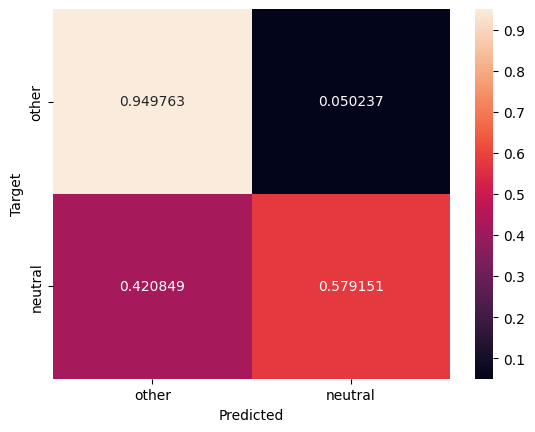

In [81]:
plot_cm(cm)
